In [2]:
# --- Import needed libraries ---
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [3]:
# --- Configuration ---
DATA_DIR = "dataset"
SEASONS = ["18_19", "19_20", "20_21", "21_22", "22_23", "23_24"]
LEAGUES = ["E0", "F1", "D1", "I1", "SP1"]  # EPL, Ligue 1, Bundesliga, Serie A, La Liga

In [4]:
# --- Load Data ---
def load_all_data():
    all_data = []
    for season in SEASONS:
        for league in LEAGUES:
            # Search recursively for matching files
            pattern = os.path.join(DATA_DIR, '**', f"{league}_{season}.csv")
            for path in glob(pattern, recursive=True):
                df = pd.read_csv(path)
                df['Season'] = season
                df['League'] = league
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

In [5]:
# --- Feature Engineering ---
def engineer_features(df):
    df = df.dropna(subset=['FTR', 'HomeTeam', 'AwayTeam'])
    df = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A', 'Season', 'League']]

    # Implied Probabilities
    df['Imp_H'] = 1 / df['B365H']
    df['Imp_D'] = 1 / df['B365D']
    df['Imp_A'] = 1 / df['B365A']
    
    # Normalize to sum to 1
    total = df[['Imp_H', 'Imp_D', 'Imp_A']].sum(axis=1)
    df['Imp_H'] /= total
    df['Imp_D'] /= total
    df['Imp_A'] /= total

    # Encode result
    df['Result'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

    # Encode teams
    le = LabelEncoder()
    df['HomeTeam'] = le.fit_transform(df['HomeTeam'])
    df['AwayTeam'] = le.fit_transform(df['AwayTeam'])

    # Encode League and Season
    df['League'] = LabelEncoder().fit_transform(df['League'])
    df['Season'] = LabelEncoder().fit_transform(df['Season'])

    return df.dropna()

In [6]:
# --- Exploratory Data Analysis ---
def perform_eda(df):
    print("\n--- EDA ---")
    print(df.describe())

    # Save EDA summary statistics to outputs folder
    os.makedirs("outputs", exist_ok=True)
    df.describe().to_csv("outputs/eda_summary.csv")

    # Histograms
    df['Result'].value_counts().plot(kind='bar', title='Match Outcome Distribution')
    plt.xlabel("Result (0=Home, 1=Draw, 2=Away)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("outputs/histogram_result.png")
    plt.show()

    # Scatter plot of odds vs. goals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='B365H', y='FTHG', data=df)
    plt.title('Home Odds vs Full Time Home Goals')
    plt.xlabel('Home Odds')
    plt.ylabel('Home Goals')
    plt.tight_layout()
    plt.savefig("outputs/scatter_odds_vs_goals.png")
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 6))
    corr = df[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Imp_H', 'Imp_D', 'Imp_A', 'Result']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig("outputs/correlation_matrix.png")
    plt.show()

    # Save correlation matrix to outputs folder
    corr.to_csv("outputs/eda_correlations.csv")

In [7]:
# --- Split Train/Test ---
def split_data(df):
    test_season = df['Season'].max()
    train_df = df[df['Season'] < test_season]
    test_df = df[df['Season'] == test_season]
    X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_train = train_df['Result']
    X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_test = test_df['Result']
    return X_train, X_test, y_train, y_test

In [8]:
# --- Model Training and Evaluation ---
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = []
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf')
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='macro')
        rmse = np.sqrt(root_mean_squared_error(y_test, preds))
        print(f"\n{name}")
        print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.2f}, RMSE: {rmse:.2f}")
        print(classification_report(y_test, preds))
        results.append([name, acc, f1, rmse])

    # Save results to CSV
    with open("outputs/model_evaluation.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "Accuracy", "F1 Score", "RMSE"])
        writer.writerows(results)


--- EDA ---
           HomeTeam      AwayTeam          FTHG          FTAG         B365H  \
count  10776.000000  10776.000000  10776.000000  10776.000000  10776.000000   
mean      72.134187     72.162676      1.543244      1.256867      2.787673   
std       40.837329     40.848495      1.303141      1.172737      1.899034   
min        0.000000      0.000000      0.000000      0.000000      1.030000   
25%       37.000000     37.000000      1.000000      0.000000      1.660000   
50%       76.000000     76.000000      1.000000      1.000000      2.250000   
75%      108.000000    108.000000      2.000000      2.000000      3.100000   
max      139.000000    139.000000      9.000000      9.000000     23.000000   

              B365D         B365A        Season        League         Imp_H  \
count  10776.000000  10776.000000  10776.000000  10776.000000  10776.000000   
mean       4.068811      4.376292      2.497030      2.082127      0.437992   
std        1.259401      3.510539     

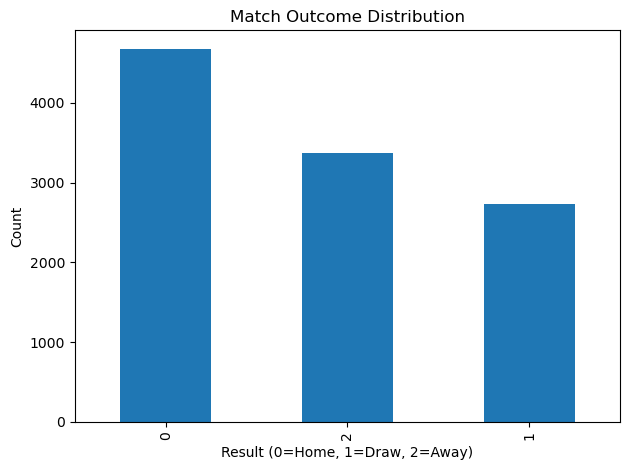

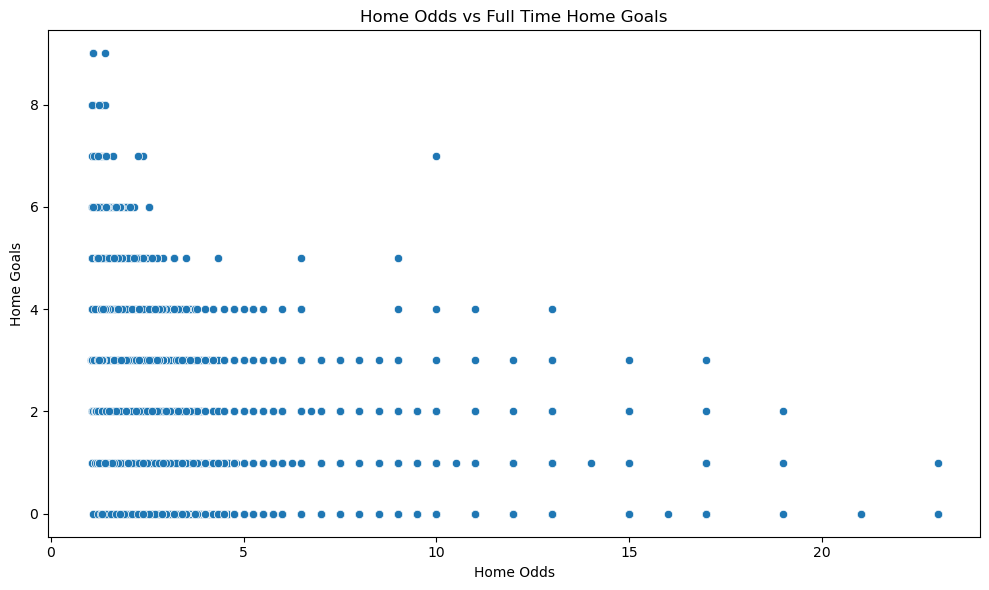

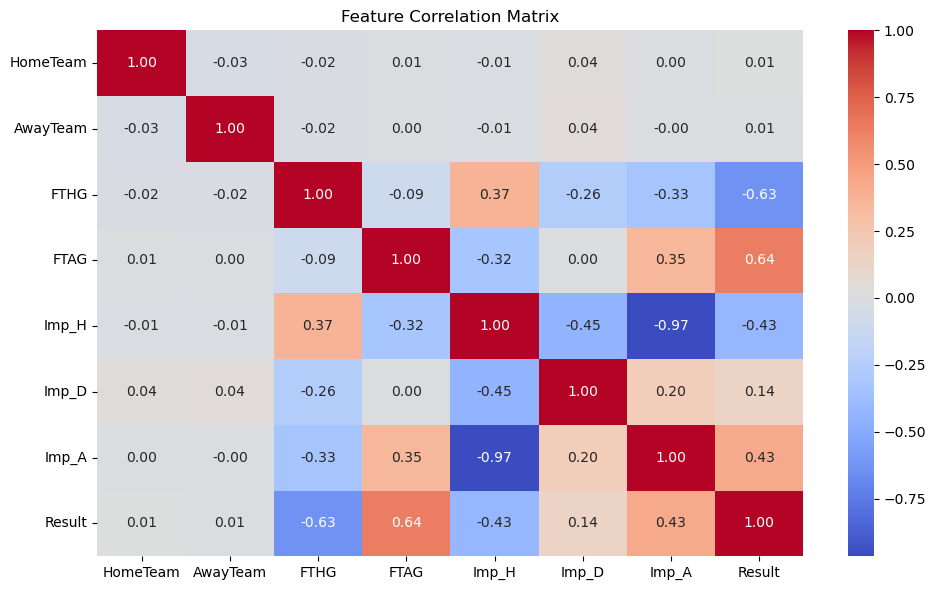

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in lab


Logistic Regression
Accuracy: 0.55, F1 Score: 0.42, RMSE: 1.00
              precision    recall  f1-score   support

           0       0.55      0.85      0.67       755
           1       0.00      0.00      0.00       463
           2       0.55      0.61      0.58       534

    accuracy                           0.55      1752
   macro avg       0.37      0.49      0.42      1752
weighted avg       0.41      0.55      0.47      1752


Random Forest
Accuracy: 0.51, F1 Score: 0.45, RMSE: 1.01
              precision    recall  f1-score   support

           0       0.57      0.72      0.63       755
           1       0.33      0.19      0.24       463
           2       0.49      0.49      0.49       534

    accuracy                           0.51      1752
   macro avg       0.46      0.46      0.45      1752
weighted avg       0.48      0.51      0.48      1752


SVM
Accuracy: 0.50, F1 Score: 0.35, RMSE: 1.05
              precision    recall  f1-score   support

           0 

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# --- Main Pipeline ---
def main():
    df = load_all_data()
    df = engineer_features(df)
    perform_eda(df)
    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()

In [ ]:
# --- Prepare test_df and test_probs for betting simulation ---

# 1. Load and process data
df = load_all_data()
df = engineer_features(df)

# 2. Split data
test_season = df['Season'].max()
train_df = df[df['Season'] < test_season]
test_df = df[df['Season'] == test_season]  # This is your test_df

X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_train = train_df['Result']
X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_test = test_df['Result']

# 3. Train Logistic Regression and get probabilities
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
test_probs = lr.predict_proba(X_test)  # This is your test_probs



In [ ]:
# --- Simulate Betting Strategy ---

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(test_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1.025
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if row['Prob_H'] > (threshold_value * row['Imp_H']):
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if row['Prob_D'] > (threshold_value * row['Imp_D']):
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if row['Prob_A'] > (threshold_value * row['Imp_A']):
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: 14.14 units
Number of bets: 1073
Average return per bet: 0.013 units


In [41]:
sim_df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Season,League,Imp_H,Imp_D,Imp_A,Result,Prob_H,Prob_D,Prob_A
0,25,84,0,3,A,8.00,5.5,1.33,5,1,0.118070,0.171738,0.710193,2,0.127086,0.141082,0.731832
1,5,98,2,1,H,1.18,7.0,15.00,5,1,0.801772,0.135156,0.063073,0,0.818397,0.109506,0.072096
2,20,137,1,1,D,2.70,3.4,2.55,5,1,0.350515,0.278351,0.371134,1,0.351172,0.270264,0.378564
3,24,79,4,1,H,1.33,5.5,9.00,5,1,0.719634,0.174020,0.106346,0,0.742538,0.154457,0.103005
4,45,51,0,1,A,2.20,3.4,3.30,5,1,0.432203,0.279661,0.288136,2,0.443674,0.279173,0.277153


In [77]:
# --- Simulate Betting Strategy ---
# filepath: c:\Users\Usuario\Desktop\NCI\SEM 3\ML FUNDAMENTALS\Adrian Tarin Martinez - x23388978\football_ml_pipeline.ipynb

# Assume you have: test_df, test_probs (from your LR model), and X_test indices match test_df
bet_results = []
stake = 1  # 1 unit per bet

# Add predicted probabilities to test_df
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(test_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df], axis=1)

# Loop through each match in test set
threshold_value = 1
for idx, row in sim_df.iterrows():
    bets = []
    # Bet on Home Win
    if 1/row['Prob_H'] < (threshold_value * row['B365H']):
        win = 1 if row['Result'] == 0 else 0
        payout = (row['B365H'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Draw
    if 1/row['Prob_D'] < (threshold_value * row['B365D']):
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        bets.append(payout - stake)
    # Bet on Away Win
    if 1/row['Prob_A'] < (threshold_value * row['B365A']):
        win = 1 if row['Result'] == 2 else 0
        payout = (row['B365A'] * stake) if win else 0
        bets.append(payout - stake)
    # Sum profit/loss for this match
    bet_results.append(sum(bets))

# Calculate total and average return
total_return = sum(bet_results)
num_bets = sum([abs(x) > 0 for x in bet_results])
avg_return = total_return / num_bets if num_bets > 0 else 0

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")

Total return: -39.59 units
Number of bets: 360
Average return per bet: -0.110 units
